In [2]:
!pip install opencv-python dlib face_recognition scikit-image numpy matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 18.0 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 87.1 MB/s eta 0:00:00:00:0100:01
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566166 sha256=8522ee2d893b416fca97c9716a000899c39de792c8bbcafd9536b160ffe855da
  Stored in directory: /root/.cache/pip/wheels/04/52/ec/9355da79c29f160b038a20c784db2803c2f9fa2c8a462c176a
Successfully built face-recognition-models
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires goog

🚀 Starting registry creation...
  -> Processing 22bce8394_1.jpg for student 22bce8394
  -> Processing 22bce8125_2.jpg for student 22bce8125
  -> Processing 22bce8394_4.jpg for student 22bce8394
  -> Processing 22mic7155_2.jpg for student 22mic7155
  -> Processing 22bce8394_2.jpg for student 22bce8394
  -> Processing 22bce8394_3.jpg for student 22bce8394
  -> Processing 22bce8876_1.jpg for student 22bce8876
  -> Processing 22bce8125_1.jpg for student 22bce8125
  -> Processing 22bce8124_4.jpg for student 22bce8124
  -> Processing 22bce8124_1.jpg for student 22bce8124
  -> Processing 22bce8124_3.jpg for student 22bce8124
  -> Processing 22bce8124_5.jpg for student 22bce8124
  -> Processing 22bce8876_4.jpg for student 22bce8876
  -> Processing 22bce8876_5.jpg for student 22bce8876
  -> Processing 22bce8394_5.jpg for student 22bce8394
  -> Processing 22bce8876_6.jpg for student 22bce8876
  -> Processing 22bce8125_4.jpg for student 22bce8125
  -> Processing 22mic7155_3.jpg for student 22mic7

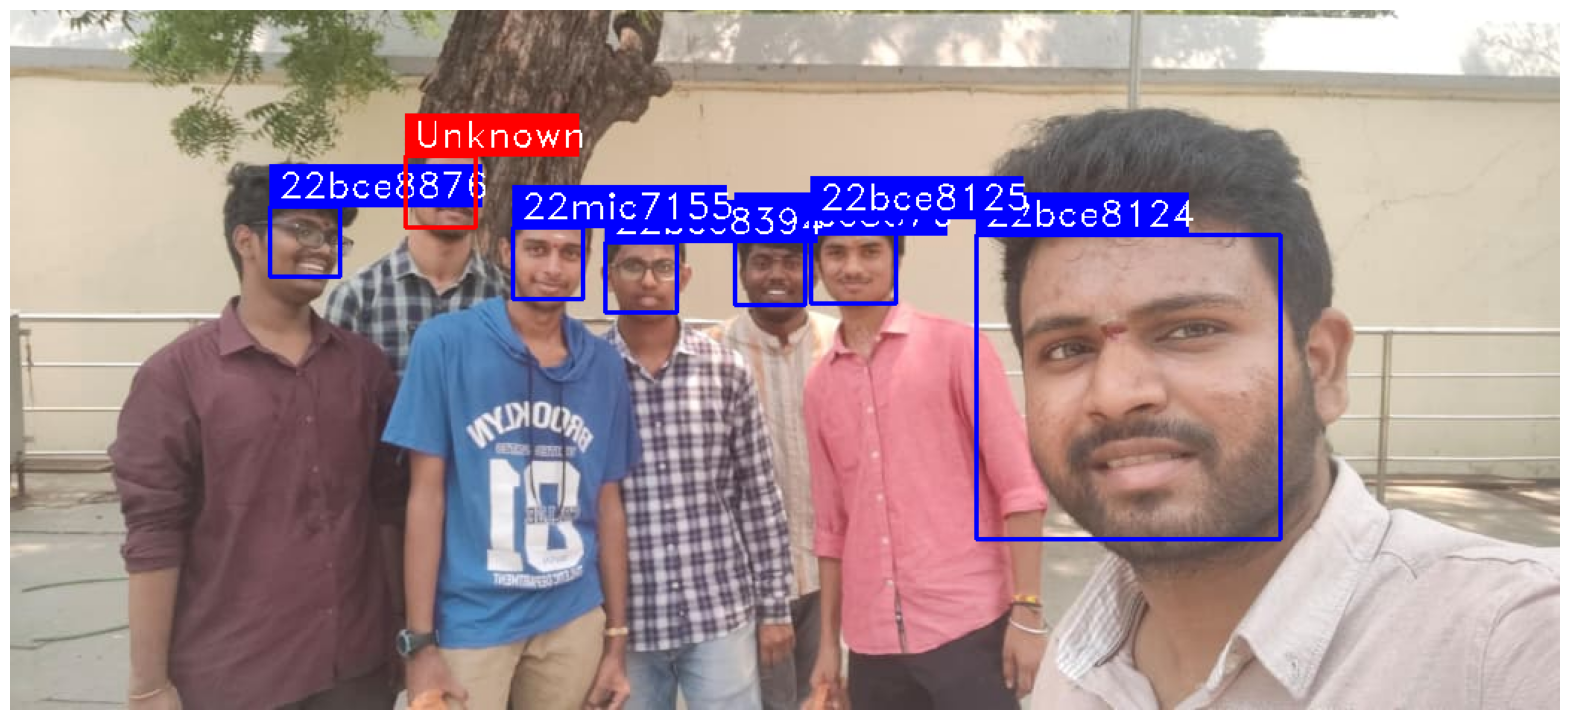

✅ Saved annotated image to: /kaggle/working/annotated_classroom_final.jpg


In [3]:
import os
import cv2
import face_recognition
import numpy as np
import pickle
from skimage.feature import hog
import collections
import matplotlib.pyplot as plt

# --- Configuration ---
DATASET_NAME = "student-faces" # The name you gave your dataset during upload
DATASET_PATH = f"/kaggle/input/friends"
CLASSROOM_IMAGE_PATH = os.path.join(DATASET_PATH, "classmate_1.jpg")
OUTPUT_DIR = "/kaggle/working/"

# --- Accuracy Settings ---
ALIGNMENT_ERROR_THRESHOLD = 5.0
RECOGNITION_TOLERANCE = 0.6
DETECTION_MODEL = "cnn" 

# --- Face Alignment Check Function ---
def is_face_aligned(face_landmarks):
    try:
        nose_bridge = face_landmarks['nose_bridge']
        left_eye = face_landmarks['left_eye']
        right_eye = face_landmarks['right_eye']
        nose_center_x = np.mean([p[0] for p in nose_bridge])
        dist_left = abs(nose_center_x - left_eye[3][0])
        dist_right = abs(nose_center_x - right_eye[0][0])
        total_dist = dist_left + dist_right
        if total_dist == 0: return False
        error = (abs(dist_left - dist_right) / (total_dist / 2)) * 100
        return error < ALIGNMENT_ERROR_THRESHOLD
    except (IndexError, KeyError):
        return False

# --- Create the Face Feature Registry ---
def create_registry(dataset_path, output_dir):
    print("🚀 Starting registry creation...")
    student_encodings_temp = collections.defaultdict(list)
    for filename in os.listdir(dataset_path):
        if "classmate" in filename: continue
        reg_num = filename.split('_')[0]
        image_path = os.path.join(dataset_path, filename)
        print(f"  -> Processing {filename} for student {reg_num}")
        image = face_recognition.load_image_file(image_path)
        face_locations = face_recognition.face_locations(image, model=DETECTION_MODEL)
        encodings = face_recognition.face_encodings(image, face_locations)
        if encodings:
            student_encodings_temp[reg_num].append(encodings[0])

    for reg_num, encodings_list in student_encodings_temp.items():
        if encodings_list:
            final_encoding = np.mean(encodings_list, axis=0)
            feature_data = {"id": reg_num, "features": final_encoding}
            id_filename = os.path.join(output_dir, f"face-{reg_num}.id")
            with open(id_filename, "wb") as f:
                pickle.dump(feature_data, f)
            print(f"  ✅ Saved registry file: {id_filename}")
    print("✅ Registry creation complete!\n")

# --- Recognize Students in the Classroom ---
def recognize_attendance(classroom_image_path, registry_path):
    known_ids, known_encodings = [], []
    for filename in os.listdir(registry_path):
        if filename.endswith(".id"):
            with open(os.path.join(registry_path, filename), "rb") as f:
                data = pickle.load(f)
                known_ids.append(data["id"])
                known_encodings.append(data["features"])
    if not known_ids:
        print("❌ Registry is empty.")
        return

    print(f"📸 Processing classroom photo with '{DETECTION_MODEL}' model...")
    image = cv2.imread(classroom_image_path)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    locations = face_recognition.face_locations(rgb_image, model=DETECTION_MODEL)
    landmarks = face_recognition.face_landmarks(rgb_image, locations)
    encodings = face_recognition.face_encodings(rgb_image, locations)
    present_students = set()
    
    for i in range(len(locations)):
        top, right, bottom, left = locations[i]
        is_aligned = True # Temporarily disabling alignment check
        
        name = "Unknown"
        color = (0, 0, 255) # Red for unknown by default
        
        if is_aligned:
            matches = face_recognition.compare_faces(known_encodings, encodings[i], RECOGNITION_TOLERANCE)
            face_distances = face_recognition.face_distance(known_encodings, encodings[i])
            best_match_index = np.argmin(face_distances)
            
            if matches[best_match_index]:
                name = known_ids[best_match_index]
                present_students.add(name)
                color = (255, 0, 0) # Blue for recognized students
        else:
            color = (0, 165, 255) # Orange for misaligned
            name = "Misaligned"
        
        # Draw the main bounding box
        cv2.rectangle(image, (left, top), (right, bottom), color, 2)

        # --- VISIBILITY UPDATE: Draw a filled background for the label ---
        # 1. Get the size of the text
        (text_width, text_height), baseline = cv2.getTextSize(name, cv2.FONT_HERSHEY_DUPLEX, 0.8, 1)
        
        # 2. Draw a filled rectangle as a background for the text
        # The label will be placed just above the main bounding box
        label_bg_top_left = (left, top - text_height - 10)
        label_bg_bottom_right = (left + text_width, top)
        cv2.rectangle(image, label_bg_top_left, label_bg_bottom_right, color, cv2.FILLED)
        
        # 3. Put the white text on top of the background
        cv2.putText(image, name, (left + 6, top - 6), cv2.FONT_HERSHEY_DUPLEX, 0.8, (255, 255, 255), 1)

    print("\n--- Attendance Report ---")
    print("Student-Registration#      Status")
    print("-----------------------------------")
    if present_students:
        for reg_num in sorted(list(present_students)):
            print(f"{reg_num.ljust(25)} Present")
    else:
        print("No students recognized.")
    print("-----------------------------------\n")

    print("🖼️ Displaying annotated image...")
    plt.figure(figsize=(20, 15))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    
    annotated_image_path = os.path.join(OUTPUT_DIR, "annotated_classroom_final.jpg")
    cv2.imwrite(annotated_image_path, image)
    print(f"✅ Saved annotated image to: {annotated_image_path}")

# --- Main Execution Block ---
if __name__ == "__main__":
    if not os.path.exists(DATASET_PATH):
        print(f"❌ ERROR: Dataset path not found at '{DATASET_PATH}'.")
    else:
        create_registry(DATASET_PATH, OUTPUT_DIR)
        recognize_attendance(CLASSROOM_IMAGE_PATH, OUTPUT_DIR)